# Image Captioning using Deep Learning: Assignment-2

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
rand=69420
np.random.seed(rand)
torch.manual_seed(rand)
from sklearn.model_selection import train_test_split
from torchvision import transforms,datasets

from sklearn.metrics import roc_auc_score

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [45]:
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

# Your Code from here...

In [46]:
# load the data set
X = train.data
y= train.targets
                                          
mean = torch.mean(X,dtype=torch.float)/255
std = torch.std(X.to(torch.float),unbiased=False)/255


# normalize the dataset, won't be doing it here in later assignments
X = (X/255-mean)/std
mean = torch.mean(X,dtype=torch.float)
std = torch.std(X.to(torch.float),unbiased=False)
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=69420)

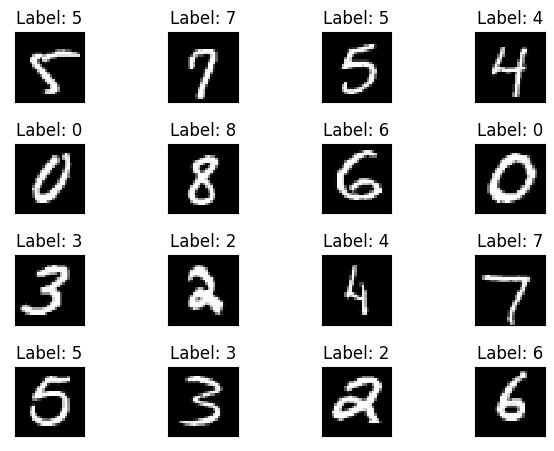

In [47]:

# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
fig = plt.figure()
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  j=int((np.random.rand()*1000)%1000)
  plt.imshow(X_train[j], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(y_train[j]))
  plt.xticks([])
  plt.yticks([])

In [48]:
# define your dataset for pre-processing into Neural Network
nn = torch.nn
F = nn.functional
optim= torch.optim 
process_data=torch.flatten(X_train,start_dim=1)
process_cross=torch.flatten(X_test,start_dim=1)

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [49]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Net(nn.Module):
    def __init__(self): 
         super(Net, self).__init__()
         self.fc1 = nn.Linear(784,196,bias=True)
         self.fc2 = nn.Linear(196, 50,bias=True)
         self.relu = nn.ReLU()
         self.fc3 = nn.Linear(50, 10,bias=True)
         
    def forward(self,x):
         x=(self.fc1(x))
         x = self.relu(x)
         x=(self.fc2(x))
         x = self.relu(x)
         x=(self.fc3(x))
         return F.softmax(x,dim=-1)




## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [50]:
def train(model, optimizer, criterion, trainloader, display_step=None):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model((data))
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
   

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [51]:
def predict(model, X_test):
    output = model(X_test)
    pred = output.data.max(0, keepdim=True)
    return int(pred.indices)

* Normal Accuracy

In [52]:
def accuracy(pred, labels):
    acc=0
    total=0
    curr=[]
    l=[]
    for i in range(len(pred)):
        total +=1
        if pred[i]==labels[i]:
            curr.append(pred[i])
            acc +=1
    return (acc/total , curr)

* AUC SCORE

In [53]:

# The ROC-AUC value for the different classes is returned in the form of a dictionary
def roc_auc_score_multiclass(y_test, predictions, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  digits = [a for a in range(0,10)]
  h = [0]*18000


  g1 = [h.copy() for i in range(10)]

  g2 = [h.copy() for i in range(10)]
  
  roc_auc_dict = {}

  for i in range(len(y_test)):
    #marking the current class as 1 and all other classes as 0
    g1[y_test[i]][i] = 1
    g2[predictions[i]][i] = 1

  for digit in digits:
    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(g1[digit], g2[digit])
    roc_auc_dict[digit] = roc_auc
  return roc_auc_dict

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [54]:
network = Net()
learning_rate = 0.01
momentum = 0.5
n_epochs=10
optimizer = optim.SGD(network.parameters(),lr=learning_rate,momentum=momentum)
criterian =  F.nll_loss
train_data = []
for i in range(process_data.size()[0]):
   train_data.append([process_data[i],y_train[i]])
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True,drop_last=True,batch_size=128)
for i in range(n_epochs):
   train(network,optimizer,criterian,trainloader)


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [55]:
b=[]
for i in process_cross:
    a=predict(network,i)
    b.append(a)
acc=accuracy(b,y_test)
print(f"Avg accuracy score is {acc[0]}")
y=roc_auc_score_multiclass(y_test,b)

Avg accuracy score is 0.90425


In [56]:
df = {'predictions': [], 'y_test': [], 'correct_pred': [],'AUC-Score': y.values()}
for i in range(0,10):
    df['predictions'].append(b.count(i))
    df['y_test'].append(list(y_test).count(i))
    df['correct_pred'].append(acc[1].count(i))


In [57]:
df = pd.DataFrame(df)
df.index.rename(inplace=True,name='Digit')
print(df) 

       predictions  y_test  correct_pred  AUC-Score
Digit                                              
0             1252    1206          1165   0.980411
1             1348    1332          1273   0.975603
2             1089    1174          1003   0.924616
3             1202    1184          1040   0.934372
4             1259    1184          1109   0.963868
5             1012    1081           886   0.906082
6             1179    1152          1090   0.970449
7             1252    1259          1164   0.959643
8             1163    1152           998   0.928263
9             1244    1276          1123   0.936429


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [58]:
#from google.colab import files
torch.save(network, 'ass_2.pt')
# files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [60]:
a=torch.load('ass_2.pt')
b=predict(a,process_cross[1])
b

6